### 丰富数据的多样性，使得模型泛化性能更好
（图片增广）
- 翻转：上下、左右
- 切割：随机高宽比、随机大小、随机位置
- 颜色：色调，饱和度，明亮度

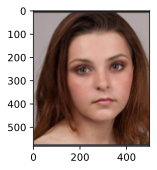

In [6]:
%matplotlib inline
import torch 
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.Image.open('face.JFIF')
d2l.plt.imshow(img);

In [8]:
def apply(img, aug, num_rows=2, num_cols=5, scale=1.5):
    Y = [aug(img) for _ in range (num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

### 翻转

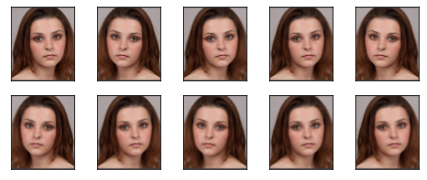

In [11]:
#水平方向随机翻转
apply(img, torchvision.transforms.RandomHorizontalFlip())

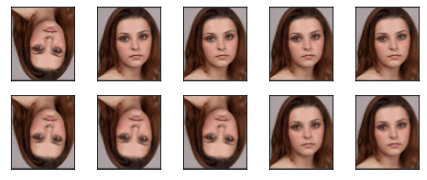

In [13]:
#上下方向随机翻转
apply(img, torchvision.transforms.RandomVerticalFlip())

### 随机裁剪

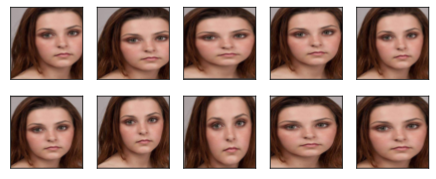

In [16]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200,200), scale=(0.6, 1), ratio=(0.5, 2))#参数：大小，保存的区域，0.1-1，高宽比
apply(img, shape_aug)

### 随机改变亮度

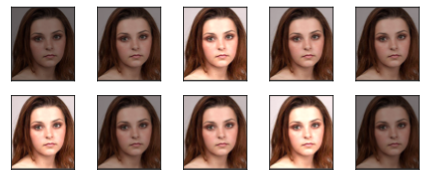

In [17]:
apply(img, torchvision.transforms.ColorJitter(
        brightness=0.5, contrast=0, saturation=0, hue=0))

### 随机改变色调

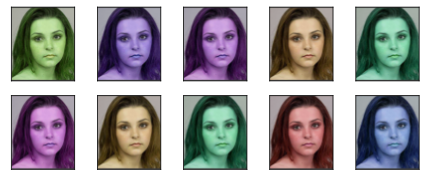

In [18]:
apply(img, torchvision.transforms.ColorJitter(
        brightness=0, contrast=0, saturation=0, hue=0.5))

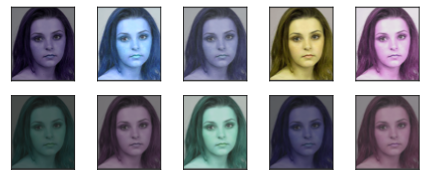

In [31]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

### 多种方法结合

In [32]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    color_aug, shape_aug])


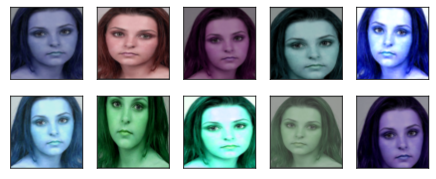

In [33]:
apply(img, augs)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data\cifar-10-python.tar.gz to ../data


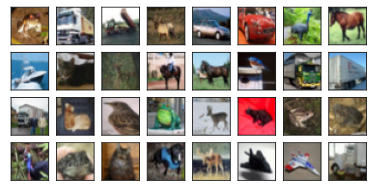

In [34]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [35]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [36]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

In [37]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需（稍后讨论）
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [38]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch 13(net, train_iter, test_iter, loss, trainer, 10, devices)

Files already downloaded and verified
Files already downloaded and verified


RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 2.00 GiB total capacity; 1.20 GiB already allocated; 0 bytes free; 1.22 GiB reserved in total by PyTorch)

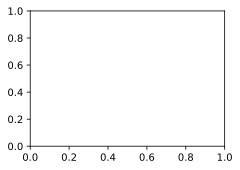

In [39]:
train_with_data_aug(train_augs, test_augs, net)